In [152]:
import random
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter
import time
import os
import pandas as pd
from scipy.signal import correlate

In [153]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [154]:
def plot_raster(params, A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse):
    import matplotlib.ticker as ticker
    M,N,D,T,nrn_fr,pg_fr,background_noise_fr = params['M'], params['N'], params['D'], params['T'], params['nrn_fr'],params['pg_fr'],params['background_noise_fr'],    

    fig, ax = plt.subplot_mosaic('AB;CD;EE;FF;GG', figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

    s = 50

    # Scatter plots for A, B, C, D
    for i, k in enumerate(['A', 'B', 'C', 'D']):
        ax[k].scatter(K_sparse[1][K_sparse[2] == i+1], K_sparse[0][K_sparse[2] == i+1], c=palette[i+1], s=s)
        ax[k].set_title(f'Spiking Motif {i + 1}')  # Updated title for plots A, B, C, D
        ax[k].set_xlabel('Time Steps')
        ax[k].set_ylabel('Neurons')
        ax[k].set_yticks(range(1, N))

    spiking_motif_data = [B_sparse[0][B_sparse[1] == i+1] for i in range(4)]  # Collect data for each Spiking Motif
    ax['E'].scatter(B_sparse[1], B_sparse[0]-1, c=palette[B_sparse[0]], s=s)
    ax['E'].set_title('Occurrences of each Spiking Motif randomly assigned')
    ax['E'].set_xlabel('Time Steps')
    ax['E'].set_ylabel('Spiking Motif')  # Updated y-axis label for plot E

    # Set y-axis ticks and labels explicitly for Spiking Motifs 1 to 4
    ax['E'].set_yticks(range(0, M))  # Set y-axis ticks for plot E to represent the four Spiking Motifs
    ax['E'].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x) + 1}'))  # Map y-axis labels to display 1 through 4
    ax['E'].set_ylim(-0.5, 3.5)  # Set y-axis limits to display only the ticks and labels for the existing values


    # Scatter plot for F
    ax['F'].scatter(A_sparse[1], A_sparse[0], c=palette[A_sparse[2]], alpha=0.9, s=s*4, marker='.')
    ax['F'].set_title('Resulting raster plot')
    ax['F'].set_xlabel('Time Steps')
    ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
    ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons

    sanity_check = np.zeros((T,M))
    for j in range(M):
        for i in range(T):
            sanity_check[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
        sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

    # Plot for G
    [ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
    ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
    ax['G'].set_xlabel('Time Steps')
    ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
    ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

    # Set common x-axis from 0 to 1000 with padding
    common_xlim = (min(A_sparse[1]), max(A_sparse[1]))
    padding = 10
    ax['E'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
    ax['F'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
    ax['G'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)

    # Share x-axis for E, F, and G
    ax['E'].sharex(ax['F'])
    ax['G'].sharex(ax['F'])

    # Hide x-axis ticks and labels for E and F
    ax['E'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax['F'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    plt.show()


In [155]:
def generate_synthetic_data(params, plot=False):
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)

    M,N,D,T,nrn_fr,pg_fr,background_noise_fr = params['M'], params['N'], params['D'], params['T'], params['nrn_fr'],params['pg_fr'],params['background_noise_fr'],    
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)

    K_dense = np.random.rand(N,D,M)*1000
    nrn_frs = np.zeros((M))
    for m in range(M):
        nrn_frs[m] = np.random.poisson(nrn_fr)
        K_dense[:,:,m] = (K_dense[:,:,m] < nrn_frs[m]).astype('int')
    K_sparse = np.where(K_dense)
    K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)


    # dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
    # spare B: set of all times t and pg's b
    B_dense = np.random.rand(M,T)*1000
    pg_frs = np.zeros((M))
    for m in range(M):
        pg_frs[m] = np.random.poisson(pg_fr)
        B_dense[m,:] = (B_dense[m,:] < pg_frs[m]).astype('int')
    B_sparse = np.where(B_dense)
    B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

    # now to make the full raster plot keeping the labels in-tact
    # dense A: the layered binary images of all neuron spikes by PG ( N x T x M
    A_dense = np.zeros((N,T+D,M+1))
    A_dense[...,0] = np.random.rand(N,T+D)*1000
    A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
    for i in range(len(B_sparse[0])):
        t = B_sparse[1][i]
        b = B_sparse[0][i]
        A_dense[:, t:t+D, b] += K_dense[...,b-1]

    A_sparse = np.where(A_dense)
    A_dense = np.sum(A_dense,axis=2)
    A_dense[A_dense>1] = 1
    
    stats = _get_stats(A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse)
    
    if plot:
        plot_raster(params, A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse)
    
    return A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse, stats

def _get_stats(A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse):
    spikes_per_motif = np.sum(K_dense,axis=(0,1))
    motif_appearances = np.sum(B_dense,axis=1)
    total_spikes = np.sum(A_dense)
    snr = total_spikes - spikes_per_motif*motif_appearances
    snr[snr<0] = 0
    snr = (spikes_per_motif*motif_appearances)/snr
    return spikes_per_motif.tolist(), motif_appearances.tolist(), total_spikes.tolist(), snr.tolist()

In [176]:
def scan_raster(T_labels, N_labels, window_dim = None):
    import time
    '''
    T_labels an array of spiketimes
    N_labels corresponding array of neuron labels
    window_dim is the size of the window to cluster the spikes
    '''
    start = time.time()
    if window_dim == None:
        window_dim = 100
        
    T_labels = np.round(T_labels).astype(int)
    T_labels, N_labels = np.unique(np.array([T_labels,N_labels]),axis=1) # This removes any spikes that occur at the same neuron at the same time
    N=max(N_labels)+1

    print(f'{len(T_labels)} Windows')
    windows = np.zeros((len(T_labels)),dtype='object')
    for i,window_time in enumerate(T_labels):
        condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
        window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
        window =  {tuple(row) for row in  window}
        windows[i] = window
        print(f'Windowing... {round(100*i/len(T_labels))}%',end='\r')
        
   
    max_iter = 50
    x = np.arange(0,100)
    fun = lambda x,c : x**(1+c)/10**(2*c+1)
    list_cutoffs = 0.01 + np.concatenate(((np.arange(0,100)/100)[:15], np.round(fun(x,.8),2)[10:25],np.round(fun(x,.8),2)[25::4],[10]))

    opt_cutoff = 0
    max_seq_rep = 0
    sim_mats = _get_sim_mats(windows, T_labels, N_labels)
    end = time.time()
    print(f'window time: {end - start}')
    
    
    print("Clustering...",end="\r")

    start = time.time()
    for i, cutoff in enumerate(list_cutoffs): 
        clusters = _cluster_windows(cutoff, N_labels, sim_mats)
        cluster_sq, _sq_counts, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)

        if len(sublist_keys_filt) != 0:
            max_ = np.max([len(k) for k in sublist_keys_filt])
            if max_seq_rep < max_:
                max_seq_rep = max_
                opt_cutoff=cutoff

        print(f'progress - {100*i/max_iter}% | cutoff - {cutoff} | opt_cutoff - {opt_cutoff} | most_detections - {max_seq_rep}',end='\r')

    clusters = _cluster_windows(opt_cutoff, N_labels, sim_mats)
    cluster_sq, sq_counts, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)
    
    end = time.time()
    print(f'cluster time: {end - start}')

    ''' to get the timings'''

    # Sort y according to x
    sorted_indices = np.argsort(T_labels)
    sorted_x = T_labels[sorted_indices]
    
    print("Re-Clustering...",end="\r")

    all_times = []
    all_labels = []
    for key in sublist_keys_filt:
        pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
        for i,k in enumerate(cluster_sq[str(key)]):
            pattern_repetition_labels[i][clusters==k] = 1
            pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
        pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
        all_labels.append(pattern_repetition_labels)

        sorted_y = pattern_repetition_labels[sorted_indices]
        pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
        all_times.append(pattern_times)
        
    print("Extracting templates...",end="\r")

    pattern_template = []
    patterns = []
    for i in range(len(all_times)):
        pattern = []
        pattern_template.append([])
        for time in all_times[i]:
            condition = (T_labels > time-window_dim*2) & (T_labels < time + window_dim*2)
            pattern = [tuple(k) for k in np.array([T_labels[condition]-time, N_labels[condition]]).T] # creating a list of tuples
            pattern_template[-1] += pattern # adds all points of each pattern to template_pattern
            patterns.append(pattern)
        print(f"Extracting templates... {round(100*i/len(all_times))}%",end="\r")
    
    print(f"{len(pattern_template)} patterns found...")

    for i,pattern in enumerate(pattern_template):
        counts = [pattern.count(k) for k in pattern]
        pattern_template[i] = np.array(pattern)[np.where(counts == np.max(counts))[0]]
        pattern_template[i][:,0] -= min(pattern_template[i][:,0])
        pattern_template[i] = np.unique(pattern_template[i],axis=0)
        
    return pattern_template, sublist_keys_filt

def _get_sim_mats(windows, T_labels, N_labels):
    sim_mats = np.zeros(np.max(N_labels)+1,dtype='object')
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        windows_n = windows[idc]
        if len(windows_n) > 1:
            x = np.zeros((len(windows_n),len(windows_n)))
            for i in range(windows_n.shape[0]):
                for j in range(windows_n.shape[0]):
                    common_rows = windows_n[i].intersection(windows_n[j])
                    num_identical_rows = len(common_rows)
                    x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
            np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
            sim_mats[n] = x-1 
        print(f"Generating sim matrices {round(n*100/np.max(N_labels))}%", end = "\r")
    return sim_mats

def _cluster_windows(cutoff, N_labels, sim_mats):
    clusters = np.zeros_like(N_labels)
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        if (type(sim_mats[n]) == np.ndarray) and (not np.all(sim_mats[n] == 0)):
            l = max(clusters)+1
            clusters[idc]= l+fcluster(linkage(sim_mats[n], method='complete'), cutoff, criterion='distance')
    return clusters

def _check_seq(clusters, T_labels, N_labels):

    time_differences = []
    cluster_sq = {}
    for cluster in np.unique(clusters):
        temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
        str_temp = str(temp)
        time_differences.append(temp)
        if str_temp in cluster_sq.keys():
            cluster_sq[str_temp] = cluster_sq[str_temp] + [cluster]
        else:
            cluster_sq[str_temp] = [cluster]

    # Convert the list of lists to a set of tuples to remove duplicates
    unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

    # Convert the set of tuples back to a list of lists
    unique_sublists = [list(sublist) for sublist in unique_sublists_set]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    # Print the unique sublists and their respective counts
    sq_counts = np.zeros(len(sublist_counts)) 
    for i,sublist in enumerate(unique_sublists):
        count = sublist_counts[tuple(sublist)]
        sq_counts[i] = count
    #     print(f"{sublist}: {count} occurrences")
    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron
    sublist_keys_filt = [list(k) for k in sublist_keys_filt]
    
    return cluster_sq, sq_counts, sublist_keys_filt


In [157]:
def get_acc(matrix_x,matrix_y):
    # Calculate cross-correlation matrix
    cross_corr_matrix = np.zeros((matrix_x.shape[2], matrix_y.shape[2]))

    for x_channel_idx in range(matrix_x.shape[2]):
        for y_channel_idx in range(matrix_y.shape[2]):
            cross_corr_matrix[x_channel_idx, y_channel_idx], _ = max_overlap(matrix_x[...,x_channel_idx],matrix_y[...,y_channel_idx])
    SM_acc_m1 = np.max(cross_corr_matrix,axis=1)
    return SM_acc_m1, cross_corr_matrix

In [158]:
def max_overlap(image, kernel):
    result = np.zeros((image.shape[1]+kernel.shape[1]-1))
    for n in range(image.shape[0]):
        result += correlate(image[n,:], kernel[n,:], mode = 'full')
    return np.max(result)/max(np.sum(image),np.sum(kernel)), np.argmax(result)

In [ ]:
def get_imgs(N_labels, pattern_template):
    if len(pattern_template) == 0:
        print('FAIL')
        return pattern_template, None
    
    win_size = (K_dense.shape[0],1+max([max(k[:,0]) for k in pattern_template]))
    pattern_img = np.zeros((len(pattern_template),*win_size))
    for p,pattern in enumerate(pattern_template):
        for (i,j) in pattern:
            pattern_img[p,j,i] = 1
            
    pattern_img = pattern_img.transpose((1,2,0))
    
    return pattern_template, pattern_img

In [165]:
default_params = {
    'M':4,
    'N':60,
    'D':71,
    'T':20000,
    'nrn_fr':5,
    'pg_fr':5,
    'background_noise_fr':5,
    'seed':1
}
np.random.seed(default_params['seed'])
scan_dict = {
    'M':[1,2,4,8,16,32,64,128],
    'N':[5,10,15,20,40,80,160,200],
    'D':[5,11,21,31,51,71,101,151,201],
    'T':[500,1000,1500,2000,5000],
    'nrn_fr':[5,10,15,20,25,35,50],
    'pg_fr':[4,5,8,10,15,20],
    'background_noise_fr':[0,2.5,5,7.5,10,12.5,15,20]
}

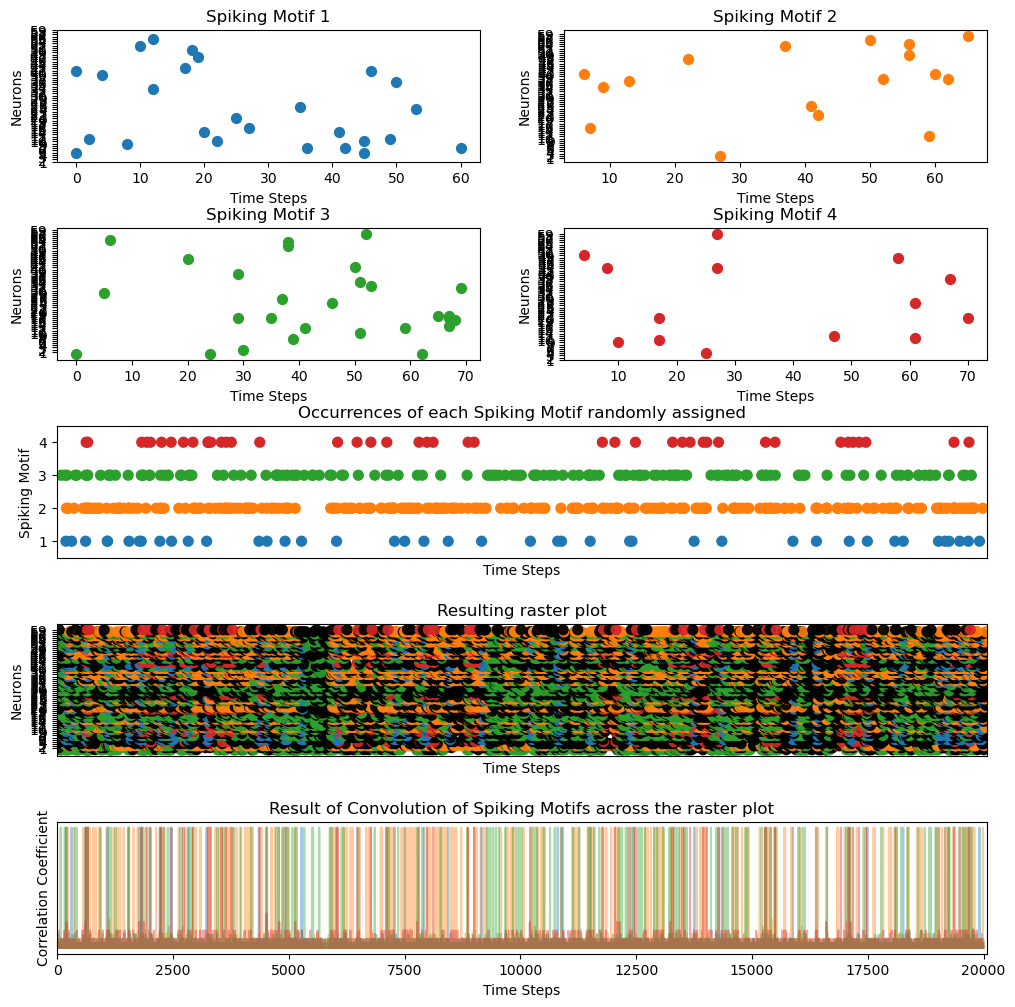

In [166]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse, stats = generate_synthetic_data(default_params, plot= True)

In [167]:
T_labels, N_labels, win_dim = A_sparse[1], A_sparse[0], default_params['D']
start = time.time()
pattern_template, sublist_keys_filt, pattern_img = scan_raster(T_labels, N_labels, win_dim)
end = time.time()
print(f'total time: {end-start}')

16047 Windows
window time: 46.1879825592041
cluster time: 98.1900970935821501 | opt_cutoff - 2.78 | most_detections - 257ections - 257tections - 148
7 patterns found...s... 86%
total time: 537.8962075710297


In [173]:
SM_acc_m1, cross_corr_matrix = get_acc(K_dense, pattern_img)

In [174]:
SM_acc_m1

array([1.        , 1.        , 1.        , 0.05882353])

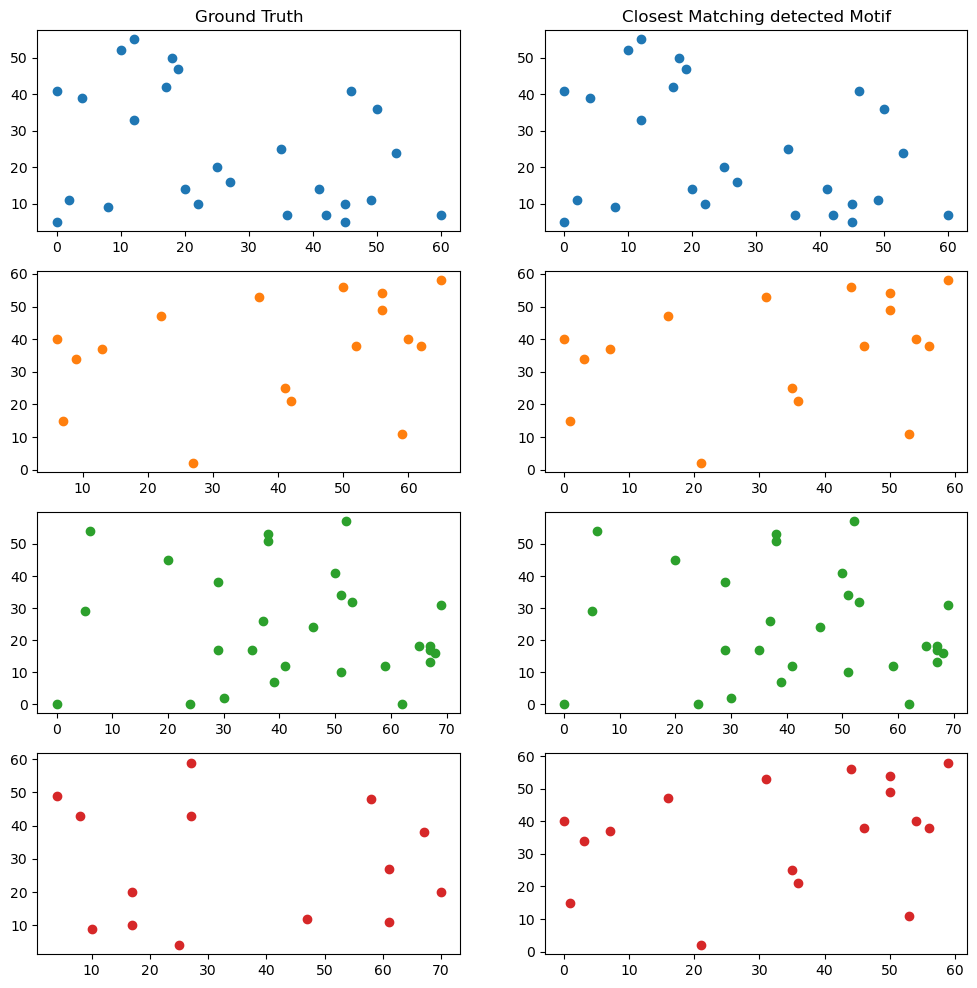

In [175]:
M = K_dense.shape[2]
motif_map = (np.arange(0,M),np.argmax(cross_corr_matrix,axis=1))
motif_map
fig,ax = plt.subplots(len(motif_map[0]),len(motif_map),figsize=(12,M*3))
for i,(a,b) in enumerate(zip(motif_map[0],motif_map[1])):
    ax[i,0].scatter(np.where(K_dense[...,a])[1],np.where(K_dense[...,a])[0],c=palette[i+1])
    ax[i,1].scatter(np.where(pattern_img[...,b])[1],np.where(pattern_img[...,b])[0],c=palette[i+1])

ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Closest Matching detected Motif')
plt.show()